## Pipeline ETL de Taxis de NYC con PySpark y Particionamiento



In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, round, floor, format_string, desc, avg, count
import matplotlib.pyplot as plt
import pandas as pd

SpSession = SparkSession \
          .builder \
          .master("local[*]") \
          .appName("TaxiProject") \
          .getOrCreate()
SpContext = SpSession.sparkContext

## Extract

In [3]:
# 1. Descarga de datos
!wget -q -N https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-08.parquet
!wget -q -N -O zonas.csv https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv

# Cargamos el Parquet principal
df_taxi = SpSession.read.parquet("yellow_tripdata_2025-08.parquet")

# Cargamos el CSV de zonas
df_zonas = SpSession.read.csv("zonas.csv", header=True, inferSchema=True)

print(f"Cantidad de viajes cargados: {df_taxi.count()}")

Cantidad de viajes cargados: 3574091


## Transform (Limpieza y Feature Engineering)

In [4]:
# PASO A: Crear columnas nuevas (Cálculos)
df_transformado = df_taxi \
    .withColumn("duration_minutes", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60) \
    .withColumn("usd_per_mile", round(col("total_amount") / col("trip_distance"), 2)) \
    .withColumn("tiempo_humano", format_string("%02d:%02d", floor((col("duration_minutes") * 60) / 60), floor((col("duration_minutes") * 60) % 60)))

# PASO B: Filtrar basura (Limpieza)
# Aplicar reglas de negocio (duración > 1 min, montos positivos, etc)
df_limpio = df_transformado.filter( \
    (col("duration_minutes") > 1) & \
    (col("duration_minutes") < 240) & \
    (col("trip_distance") > 0.1) & \
    (col("total_amount") > 0) & \
    (col("passenger_count") > 0) \
)

print(f"Registros después de limpiar: {df_limpio.count()}")

Registros después de limpiar: 2496632


## Enrich (Unión con Zonas) & Load (Guardado)

In [5]:
# 1. Join con Zonas (Left Join para no perder viajes si la zona es desconocida)
df_final = df_limpio.join( \
    df_zonas, \
    df_limpio.PULocationID == df_zonas.LocationID, \
    "left" \
).drop("LocationID") # Borramos el ID repetido para que quede prolijo

# 2. Vista previa de los datos maestros
# Mostramos las columnas clave para verificar que todo calculó bien
print("Muestra del Dataset Maestro Final:")
df_final.select("tpep_pickup_datetime", "Zone", "duration_minutes", "tiempo_humano", "usd_per_mile").show(5, truncate=False)

# 3. Guardado (LOAD)
# Guardamos en Parquet para eficiencia futura
df_final.write.mode("overwrite").parquet("datos_procesados_finales")
print("¡Pipeline terminado! Datos guardados en carpeta 'datos_procesados_finales'")

Muestra del Dataset Maestro Final:
+--------------------+-----------------------+------------------+-------------+------------+
|tpep_pickup_datetime|Zone                   |duration_minutes  |tiempo_humano|usd_per_mile|
+--------------------+-----------------------+------------------+-------------+------------+
|2025-08-01 00:52:23 |LaGuardia Airport      |19.95             |19:57        |6.81        |
|2025-08-01 00:03:01 |LaGuardia Airport      |12.533333333333333|12:32        |6.11        |
|2025-08-01 00:25:34 |Central Park           |7.733333333333333 |07:44        |9.21        |
|2025-08-01 00:16:36 |Greenwich Village South|17.083333333333332|17:05        |7.89        |
|2025-08-01 00:56:02 |Midtown North          |19.583333333333332|19:35        |5.99        |
+--------------------+-----------------------+------------------+-------------+------------+
only showing top 5 rows
¡Pipeline terminado! Datos guardados en carpeta 'datos_procesados_finales'


## Análisis de Negocio (Insights y Gráfico)

--- TOP ZONAS POR PROPINA ---
+--------------------------------+-------+------------------+------------+
|Zone                            |Borough|propina_promedio  |total_viajes|
+--------------------------------+-------+------------------+------------+
|JFK Airport                     |Queens |12.080458451762249|119620      |
|Saint Michaels Cemetery/Woodside|Queens |11.179248554913292|173         |
|Outside of NYC                  |N/A    |10.375988538681947|349         |
|LaGuardia Airport               |Queens |10.247619452112884|80053       |
|East Elmhurst                   |Queens |9.799614728115085 |8202        |
|Elmhurst/Maspeth                |Queens |9.497675675675678 |185         |
|Baisley Park                    |Queens |9.044442036836404 |923         |
|Flushing Meadows-Corona Park    |Queens |8.740280760969586 |6518        |
|Long Island City/Hunters Point  |Queens |8.294553429027115 |1254        |
|Sunnyside                       |Queens |8.261189504373192 |1715     

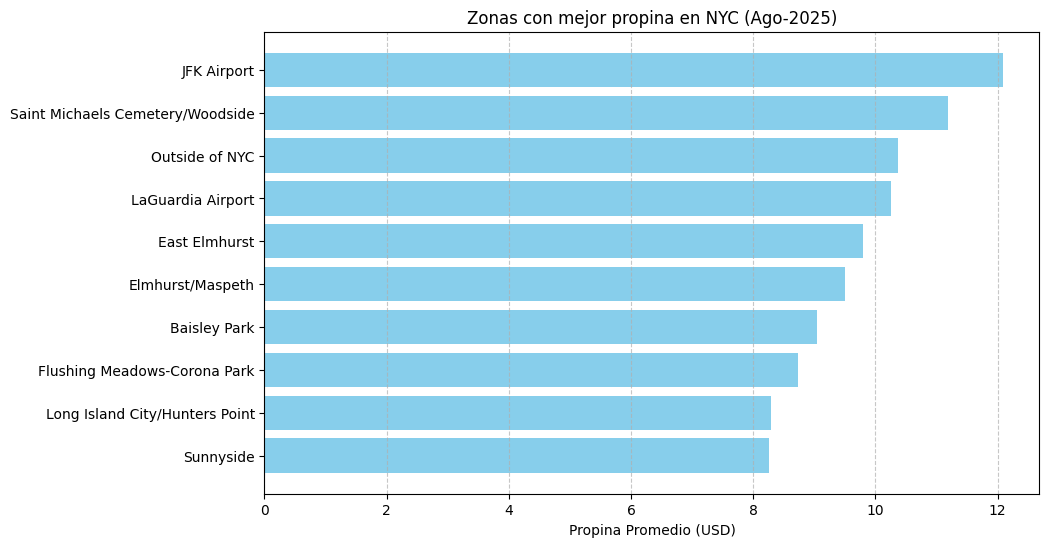

In [6]:
# Análisis: Mejores zonas para trabajar (Basado en propina promedio con tarjeta)
df_ranking = df_final \
    .filter(col("payment_type") == 1) \
    .groupBy("Zone", "Borough") \
    .agg( \
        avg("tip_amount").alias("propina_promedio"), \
        count("*").alias("total_viajes") \
    ) \
    .filter(col("total_viajes") > 50) \
    .orderBy(desc("propina_promedio"))

print("--- TOP ZONAS POR PROPINA ---")
df_ranking.show(10, truncate=False)

# Visualización con Pandas y Matplotlib basico.
pdf_grafico = df_ranking.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(pdf_grafico["Zone"], pdf_grafico["propina_promedio"], color='skyblue')
plt.xlabel("Propina Promedio (USD)")
plt.title("Zonas con mejor propina en NYC (Ago-2025)")
plt.gca().invert_yaxis() # Invertimos para que el #1 quede arriba
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()